# DQN (train)
https://simoninithomas.github.io/Deep_reinforcement_learning_Course/  
https://medium.freecodecamp.org/an-introduction-to-deep-q-learning-lets-play-doom-54d02d8017d8  
https://medium.freecodecamp.org/improvements-in-deep-q-learning-dueling-double-dqn-prioritized-experience-replay-and-fixed-58b130cc5682  
https://github.com/yandexdataschool/Practical_RL/blob/master/week4_approx_rl/homework_pytorch.ipynb  
http://maciejjaskowski.github.io/2016/03/09/space-invaders.html  
https://storage.googleapis.com/deepmind-data/assets/papers/DeepMindNature14236Paper.pdf

## 1. Setup

In [1]:
import config
import gym
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import sys

from collections import deque
from dqn import DQN
from preprocessing import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

print(f'sys.version: {sys.version}')
print(f'skimage.version: {skimage.__version__}')
print(f'tf.version: {tf.__version__}')

sys.version: 3.6.7 |Anaconda, Inc.| (default, Oct 23 2018, 19:16:44) 
[GCC 7.3.0]
skimage.version: 0.14.1
tf.version: 1.11.0


## 2. Look at our env

In [2]:
env = gym.make(config.GAME_NAME)
state = env.reset()
print(f'Game: {config.GAME_NAME}')
print('A state (in env, not in our dqn) is represented by a frame')
print(type(state), state.dtype)
print(state.shape)

Game: Pong-v0
A state (in env, not in our dqn) is represented by a frame
<class 'numpy.ndarray'> uint8
(210, 160, 3)


In [3]:
print(f'Num_Actions: {env.action_space.n}')
action_meanings = env.unwrapped.get_action_meanings()
for i in range(env.action_space.n):
    print(f'{i}: {action_meanings[i]}')

Num_Actions: 6
0: NOOP
1: FIRE
2: RIGHT
3: LEFT
4: RIGHTFIRE
5: LEFTFIRE


__Look how the rgb frame is preprocessed__

initial: uint8
preprocessed_frame: uint8, [62, 236]


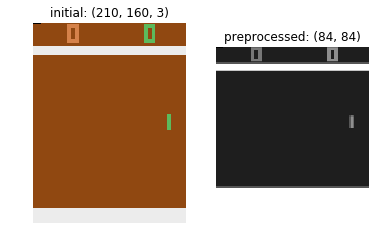

In [4]:
env.reset()
rgb_frame, _, _, _ = env.step(1)
preprocessed_frame = preprocess_frame(rgb_frame)

print(f'initial: {rgb_frame.dtype}')
print(f'preprocessed_frame: {preprocessed_frame.dtype}'
      f', [{preprocessed_frame.min()}, {preprocessed_frame.max()}]')

plt.figure()

plt.subplot(1, 2, 1)
plt.title(f'initial: {rgb_frame.shape}')
plt.axis('off')
plt.imshow(rgb_frame)

plt.subplot(1, 2, 2)
plt.title(f'preprocessed: {preprocessed_frame.shape}')
plt.axis('off')
plt.imshow(preprocessed_frame, cmap='gray')

plt.show()

## 3. DQN

### CNN architecture
1. Conv2d(filters=32, kernel_size=8, strides=4, padding='valid', activation=ReLU)
2. Conv2d(filters=64, kernel_size=4, strides=2, padding='valid', activation=ReLU)  
3. Conv2d(filters=64, kernel_size=3, strides=1, padding='valid', activation=ReLU) -> Flatten()  
4. FC(512, activation=ReLU)
5. FC(NUM_ACTIONS, activation=Linear)

### Instantiate DQNs: DQN and TargetDQN

In [5]:
tf.reset_default_graph()

dqn = DQN(action_size=env.action_space.n, dqn_name='DQN')
dqn_target = DQN(action_size=env.action_space.n, dqn_name='DQNTarget')

## 4. Training

### Memory class (for Experience Replay)

In [6]:
class Memory:
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)
        
    def add(self, experience):
        self.buffer.append(experience)
        
    def sample(self, batch_size):
        buffer_size = len(self.buffer)
        indices = np.random.choice(np.arange(buffer_size),
                                   size=batch_size,
                                   replace=False)
        experiences_batch = [self.buffer[idx] for idx in indices]
        return experiences_batch

#### Pre-populate memory by taking random actions and storing each experience (stacked_frames_hwc, action, reward, done)

In [7]:
def get_pre_populated_memory(env):
    memory = Memory(max_size=config.MEMORY_SIZE)
    stacked_frames = None
    
    # start a new episode
    state = env.reset()
    _, stacked_frames = stack_frames(stacked_frames, state, is_new_episode=True)

    for _ in range(config.PRETRAIN_LENGTH):            
        # random action
        action = env.action_space.sample() 
        
        # next state
        next_state, reward, done, _ = env.step(action)

        if done:
            # the end of episode (next_state = 0)
            next_state = np.zeros(config.STATE_SHAPE, dtype=np.uint8)
            stacked_frames_hwc, stacked_frames = stack_frames(stacked_frames, next_state,
                                                              is_new_episode=False)

            # add experience to memory
            memory.add((stacked_frames_hwc, action, reward, done))

            # start a new episode
            state = env.reset()
            _, stacked_frames = stack_frames(stacked_frames, state,
                                             is_new_episode=True)
        else:
            # add experience to memory
            stacked_frames_hwc, stacked_frames = stack_frames(stacked_frames, next_state,
                                                              is_new_episode=False)
            memory.add((stacked_frames_hwc, action, reward, done))
    
    return memory

### Helper function to copy DQN parameters to DQNTarget

In [8]:
def update_dqn_target():
    from_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'DQN')
    to_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'DQNTarget')
    
    op_holder = []
    for from_var, to_var in zip(from_vars, to_vars):
        op_holder.append(to_var.assign(from_var))
        
    return op_holder

### DQN (training algorithm)

In [9]:
def eps_greedy(sess, state, step):
    # eps: exploration probability
    # linear decaying for config.DECAY_STEPS (config.EPS_START ---> config.EPS_END)
    eps = config.EPS_END
    if step <= config.DECAY_STEPS:
        eps = config.EPS_START - step * config.DECAY_STEP_LENGTH
    
    if np.random.rand() < eps:
        # exploration with eps probability
        action = env.action_space.sample()
    else:
        # exploitation with (1 - eps) probability
        Q = sess.run(dqn.output,
                     feed_dict={
                         dqn.input_ph: state[np.newaxis]
                     })
        
        action = np.argmax(Q)

    return action, eps

In [10]:
def dqn_training(dqn, dqn_target):
    
    # memory for experience replay
    memory = get_pre_populated_memory(env)
    
    # update dqn target op
    update_dqn_target_op = update_dqn_target()    
    
    # to save some ckpts
    saver = tf.train.Saver(max_to_keep=30)
    
    with tf.Session() as sess:
        # init tf variables
        sess.run(tf.global_variables_initializer())
        
        # init dqn_target with the same params as dqn
        sess.run(update_dqn_target_op)
        
        step = 0
        iters_per_episode = []
        reward_per_episode = []
        loss_per_iter = []
        
        for episode in range(1, config.NUM_EPISODES + 1):
            episode_step = 0
            done = False
            stacked_frames = None
            episode_rewards = []
            
            # new episode
            state = env.reset()
            stacked_frames_hwc, stacked_frames = stack_frames(stacked_frames, state,
                                                              is_new_episode=True)
            
            while not done:
                episode_step += 1
                step += 1
                
                # eps-gredy
                current_state = stacked_frames_hwc[:,:,-config.STACK_SIZE:]
                action, eps = eps_greedy(sess, current_state, step)
                
                next_state, reward, done, _ = env.step(action)
                episode_rewards.append(reward)
                
                if done:
                    # the end of episode (next_state = 0)
                    next_state = np.zeros(config.STATE_SHAPE, dtype=np.uint8)
                    stacked_frames_hwc, stacked_frames = stack_frames(stacked_frames, next_state,
                                                                      is_new_episode=False)
                    # add experience to memory
                    memory.add((stacked_frames_hwc, action, reward, done))
                    
                    total_reward = np.sum(episode_rewards)
                    reward_per_episode.append(total_reward)
                    iters_per_episode.append(episode_step)
                    
                    print(f'Episode: {episode}, '
                          f'Total reward: {total_reward}, '
                          f'Epsilon: {eps:.5f}, '
                          f'Episode steps: {episode_step}\n'
                          f'Total training steps after {episode} episodes: {step}')
                else:
                    stacked_frames_hwc, stacked_frames = stack_frames(stacked_frames, next_state,
                                                                      is_new_episode=False)
                    # add experience to memory
                    memory.add((stacked_frames_hwc, action, reward, done))

                ### learning part ###
                # sample a random batch of experiences from memory
                batch = memory.sample(config.BATCH_SIZE)
                batch_states = np.array([experience[0][:,:,:-1] for experience in batch]) / 255.
                batch_next_states = np.array([experience[0][:,:,1:] for experience in batch]) / 255.
                batch_actions = np.array([experience[1] for experience in batch])
                batch_rewards = np.array([experience[2] for experience in batch])
                batch_dones = np.array([experience[3] for experience in batch])
                
                # if the episode ends at next_state:
                #     Q_target(state) = reward
                # else:
                #     Q_target(state) = reward + gamma * max(a){Q_next_state}
                Q_batch_next_state = sess.run(dqn_target.output,
                                              feed_dict={
                                                  dqn_target.input_ph: batch_next_states
                                              })
                
                # terminal states => Q value = 0
                Q_batch_next_state[batch_dones, :] = 0
                
                Q_target = batch_rewards + config.GAMMA * np.max(Q_batch_next_state, axis=1)
                
                loss, _ = sess.run([dqn.loss, dqn.optimization_step],
                                   feed_dict={
                                       dqn.input_ph: batch_states,
                                       dqn.actions_ph: batch_actions,
                                       dqn.Q_target_ph: Q_target,
                                   })
                
                loss_per_iter.append(loss)
                
                if step % config.Q_TARGET_UPDATE_FREQ == 0:
                    print('Update parameters of DQNTarget')
                    sess.run(update_dqn_target_op)
                    
                del batch
                del batch_states
                del batch_next_states
                del batch_actions
                del batch_rewards
                del batch_dones
                
            if (episode in [1, config.NUM_EPISODES]) or (episode % config.SAVE_EVERY == 0):
                saver.save(sess, f'{config.SAVE_PATH}/model_episode_{episode}.ckpt')
                print('Model saved')
                
    return iters_per_episode, reward_per_episode, loss_per_iter

In [11]:
%%time
!rm -rf $config.SAVE_PATH
train_stats = dqn_training(dqn, dqn_target)

Episode: 1, Total reward: -20.0, Epsilon: 0.99559, Episode steps: 1337
Total training steps after 1 episodes: 1337
Model saved
Episode: 2, Total reward: -21.0, Epsilon: 0.99224, Episode steps: 1014
Total training steps after 2 episodes: 2351
Update parameters of DQNTarget
Episode: 3, Total reward: -21.0, Epsilon: 0.98857, Episode steps: 1113
Total training steps after 3 episodes: 3464
Episode: 4, Total reward: -21.0, Epsilon: 0.98494, Episode steps: 1099
Total training steps after 4 episodes: 4563
Episode: 5, Total reward: -21.0, Epsilon: 0.98111, Episode steps: 1162
Total training steps after 5 episodes: 5725
Update parameters of DQNTarget
Episode: 6, Total reward: -21.0, Epsilon: 0.97774, Episode steps: 1019
Total training steps after 6 episodes: 6744
Episode: 7, Total reward: -21.0, Epsilon: 0.97390, Episode steps: 1166
Total training steps after 7 episodes: 7910
Update parameters of DQNTarget
Episode: 8, Total reward: -20.0, Epsilon: 0.97009, Episode steps: 1153
Total training step

Update parameters of DQNTarget
Episode: 64, Total reward: -20.0, Epsilon: 0.74249, Episode steps: 1198
Total training steps after 64 episodes: 78032
Episode: 65, Total reward: -21.0, Epsilon: 0.73896, Episode steps: 1070
Total training steps after 65 episodes: 79102
Episode: 66, Total reward: -20.0, Epsilon: 0.73529, Episode steps: 1114
Total training steps after 66 episodes: 80216
Update parameters of DQNTarget
Episode: 67, Total reward: -21.0, Epsilon: 0.73147, Episode steps: 1158
Total training steps after 67 episodes: 81374
Episode: 68, Total reward: -20.0, Epsilon: 0.72748, Episode steps: 1207
Total training steps after 68 episodes: 82581
Episode: 69, Total reward: -20.0, Epsilon: 0.72360, Episode steps: 1178
Total training steps after 69 episodes: 83759
Update parameters of DQNTarget
Episode: 70, Total reward: -20.0, Epsilon: 0.71932, Episode steps: 1297
Total training steps after 70 episodes: 85056
Episode: 71, Total reward: -20.0, Epsilon: 0.71453, Episode steps: 1449
Total tra

Episode: 126, Total reward: -20.0, Epsilon: 0.46723, Episode steps: 1398
Total training steps after 126 episodes: 161446
Update parameters of DQNTarget
Episode: 127, Total reward: -20.0, Epsilon: 0.46273, Episode steps: 1364
Total training steps after 127 episodes: 162810
Episode: 128, Total reward: -20.0, Epsilon: 0.45831, Episode steps: 1339
Total training steps after 128 episodes: 164149
Update parameters of DQNTarget
Episode: 129, Total reward: -21.0, Epsilon: 0.45442, Episode steps: 1179
Total training steps after 129 episodes: 165328
Episode: 130, Total reward: -19.0, Epsilon: 0.44920, Episode steps: 1581
Total training steps after 130 episodes: 166909
Update parameters of DQNTarget
Episode: 131, Total reward: -21.0, Epsilon: 0.44529, Episode steps: 1186
Total training steps after 131 episodes: 168095
Episode: 132, Total reward: -19.0, Epsilon: 0.43948, Episode steps: 1759
Total training steps after 132 episodes: 169854
Update parameters of DQNTarget
Episode: 133, Total reward: -

Episode: 185, Total reward: -16.0, Epsilon: 0.10115, Episode steps: 2258
Total training steps after 185 episodes: 272378
Update parameters of DQNTarget
Episode: 186, Total reward: -19.0, Epsilon: 0.09481, Episode steps: 1922
Total training steps after 186 episodes: 274300
Update parameters of DQNTarget
Episode: 187, Total reward: -17.0, Epsilon: 0.08750, Episode steps: 2216
Total training steps after 187 episodes: 276516
Update parameters of DQNTarget
Episode: 188, Total reward: -16.0, Epsilon: 0.07885, Episode steps: 2620
Total training steps after 188 episodes: 279136
Episode: 189, Total reward: -19.0, Epsilon: 0.07050, Episode steps: 2531
Total training steps after 189 episodes: 281667
Update parameters of DQNTarget
Episode: 190, Total reward: -18.0, Epsilon: 0.06103, Episode steps: 2870
Total training steps after 190 episodes: 284537
Update parameters of DQNTarget
Episode: 191, Total reward: -20.0, Epsilon: 0.05298, Episode steps: 2438
Total training steps after 191 episodes: 28697

Episode: 239, Total reward: -14.0, Epsilon: 0.01000, Episode steps: 3838
Total training steps after 239 episodes: 433609
Update parameters of DQNTarget
Episode: 240, Total reward: -17.0, Epsilon: 0.01000, Episode steps: 3513
Total training steps after 240 episodes: 437122
Update parameters of DQNTarget
Episode: 241, Total reward: -17.0, Epsilon: 0.01000, Episode steps: 3244
Total training steps after 241 episodes: 440366
Update parameters of DQNTarget
Episode: 242, Total reward: -17.0, Epsilon: 0.01000, Episode steps: 3569
Total training steps after 242 episodes: 443935
Update parameters of DQNTarget
Update parameters of DQNTarget
Episode: 243, Total reward: -16.0, Epsilon: 0.01000, Episode steps: 3562
Total training steps after 243 episodes: 447497
Update parameters of DQNTarget
Episode: 244, Total reward: -15.0, Epsilon: 0.01000, Episode steps: 3653
Total training steps after 244 episodes: 451150
Update parameters of DQNTarget
Episode: 245, Total reward: -15.0, Epsilon: 0.01000, Epis

Update parameters of DQNTarget
Episode: 292, Total reward: -13.0, Epsilon: 0.01000, Episode steps: 3668
Total training steps after 292 episodes: 613996
Update parameters of DQNTarget
Episode: 293, Total reward: -16.0, Epsilon: 0.01000, Episode steps: 3460
Total training steps after 293 episodes: 617456
Update parameters of DQNTarget
Update parameters of DQNTarget
Episode: 294, Total reward: -15.0, Epsilon: 0.01000, Episode steps: 3581
Total training steps after 294 episodes: 621037
Update parameters of DQNTarget
Episode: 295, Total reward: -16.0, Epsilon: 0.01000, Episode steps: 3374
Total training steps after 295 episodes: 624411
Update parameters of DQNTarget
Episode: 296, Total reward: -15.0, Epsilon: 0.01000, Episode steps: 3591
Total training steps after 296 episodes: 628002
Update parameters of DQNTarget
Episode: 297, Total reward: -16.0, Epsilon: 0.01000, Episode steps: 3545
Total training steps after 297 episodes: 631547
Update parameters of DQNTarget
Episode: 298, Total reward

Update parameters of DQNTarget
Episode: 345, Total reward: -17.0, Epsilon: 0.01000, Episode steps: 2910
Total training steps after 345 episodes: 787415
Update parameters of DQNTarget
Episode: 346, Total reward: -17.0, Epsilon: 0.01000, Episode steps: 3096
Total training steps after 346 episodes: 790511
Update parameters of DQNTarget
Episode: 347, Total reward: -16.0, Epsilon: 0.01000, Episode steps: 2911
Total training steps after 347 episodes: 793422
Update parameters of DQNTarget
Episode: 348, Total reward: -16.0, Epsilon: 0.01000, Episode steps: 2581
Total training steps after 348 episodes: 796003
Update parameters of DQNTarget
Episode: 349, Total reward: -16.0, Epsilon: 0.01000, Episode steps: 3084
Total training steps after 349 episodes: 799087
Update parameters of DQNTarget
Episode: 350, Total reward: -19.0, Epsilon: 0.01000, Episode steps: 2241
Total training steps after 350 episodes: 801328
Model saved
Episode: 351, Total reward: -18.0, Epsilon: 0.01000, Episode steps: 2630
Tot

Update parameters of DQNTarget
Update parameters of DQNTarget
Episode: 399, Total reward: -14.0, Epsilon: 0.01000, Episode steps: 3459
Total training steps after 399 episodes: 957435
Update parameters of DQNTarget
Episode: 400, Total reward: -17.0, Epsilon: 0.01000, Episode steps: 3396
Total training steps after 400 episodes: 960831
Model saved
Update parameters of DQNTarget
Episode: 401, Total reward: -17.0, Epsilon: 0.01000, Episode steps: 3076
Total training steps after 401 episodes: 963907
Update parameters of DQNTarget
Episode: 402, Total reward: -14.0, Epsilon: 0.01000, Episode steps: 3306
Total training steps after 402 episodes: 967213
Update parameters of DQNTarget
Episode: 403, Total reward: -13.0, Epsilon: 0.01000, Episode steps: 3198
Total training steps after 403 episodes: 970411
Update parameters of DQNTarget
Episode: 404, Total reward: -18.0, Epsilon: 0.01000, Episode steps: 3283
Total training steps after 404 episodes: 973694
Update parameters of DQNTarget
Episode: 405, 

Update parameters of DQNTarget
Episode: 454, Total reward: -16.0, Epsilon: 0.01000, Episode steps: 2471
Total training steps after 454 episodes: 1105804
Update parameters of DQNTarget
Episode: 455, Total reward: -18.0, Epsilon: 0.01000, Episode steps: 2423
Total training steps after 455 episodes: 1108227
Update parameters of DQNTarget
Episode: 456, Total reward: -14.0, Epsilon: 0.01000, Episode steps: 2490
Total training steps after 456 episodes: 1110717
Episode: 457, Total reward: -20.0, Epsilon: 0.01000, Episode steps: 1861
Total training steps after 457 episodes: 1112578
Update parameters of DQNTarget
Episode: 458, Total reward: -19.0, Epsilon: 0.01000, Episode steps: 1641
Total training steps after 458 episodes: 1114219
Update parameters of DQNTarget
Episode: 459, Total reward: -17.0, Epsilon: 0.01000, Episode steps: 2647
Total training steps after 459 episodes: 1116866
Episode: 460, Total reward: -19.0, Epsilon: 0.01000, Episode steps: 2021
Total training steps after 460 episodes:

Episode: 509, Total reward: -17.0, Epsilon: 0.01000, Episode steps: 2546
Total training steps after 509 episodes: 1246470
Update parameters of DQNTarget
Episode: 510, Total reward: -16.0, Epsilon: 0.01000, Episode steps: 2517
Total training steps after 510 episodes: 1248987
Update parameters of DQNTarget
Episode: 511, Total reward: -20.0, Epsilon: 0.01000, Episode steps: 2271
Total training steps after 511 episodes: 1251258
Update parameters of DQNTarget
Episode: 512, Total reward: -18.0, Epsilon: 0.01000, Episode steps: 2761
Total training steps after 512 episodes: 1254019
Update parameters of DQNTarget
Episode: 513, Total reward: -14.0, Epsilon: 0.01000, Episode steps: 3200
Total training steps after 513 episodes: 1257219
Episode: 514, Total reward: -17.0, Epsilon: 0.01000, Episode steps: 2383
Total training steps after 514 episodes: 1259602
Update parameters of DQNTarget
Episode: 515, Total reward: -18.0, Epsilon: 0.01000, Episode steps: 2427
Total training steps after 515 episodes:

Episode: 565, Total reward: -18.0, Epsilon: 0.01000, Episode steps: 1949
Total training steps after 565 episodes: 1377326
Episode: 566, Total reward: -19.0, Epsilon: 0.01000, Episode steps: 1956
Total training steps after 566 episodes: 1379282
Update parameters of DQNTarget
Episode: 567, Total reward: -18.0, Epsilon: 0.01000, Episode steps: 2071
Total training steps after 567 episodes: 1381353
Update parameters of DQNTarget
Episode: 568, Total reward: -20.0, Epsilon: 0.01000, Episode steps: 1949
Total training steps after 568 episodes: 1383302
Episode: 569, Total reward: -17.0, Epsilon: 0.01000, Episode steps: 1842
Total training steps after 569 episodes: 1385144
Update parameters of DQNTarget
Episode: 570, Total reward: -19.0, Epsilon: 0.01000, Episode steps: 1972
Total training steps after 570 episodes: 1387116
Episode: 571, Total reward: -19.0, Epsilon: 0.01000, Episode steps: 1702
Total training steps after 571 episodes: 1388818
Update parameters of DQNTarget
Episode: 572, Total re

Episode: 623, Total reward: -15.0, Epsilon: 0.01000, Episode steps: 2105
Total training steps after 623 episodes: 1496241
Update parameters of DQNTarget
Episode: 624, Total reward: -17.0, Epsilon: 0.01000, Episode steps: 2078
Total training steps after 624 episodes: 1498319
Update parameters of DQNTarget
Episode: 625, Total reward: -17.0, Epsilon: 0.01000, Episode steps: 1893
Total training steps after 625 episodes: 1500212
Episode: 626, Total reward: -21.0, Epsilon: 0.01000, Episode steps: 1214
Total training steps after 626 episodes: 1501426
Update parameters of DQNTarget
Episode: 627, Total reward: -18.0, Epsilon: 0.01000, Episode steps: 2033
Total training steps after 627 episodes: 1503459
Episode: 628, Total reward: -18.0, Epsilon: 0.01000, Episode steps: 2060
Total training steps after 628 episodes: 1505519
Update parameters of DQNTarget
Episode: 629, Total reward: -20.0, Epsilon: 0.01000, Episode steps: 1401
Total training steps after 629 episodes: 1506920
Episode: 630, Total re

Episode: 683, Total reward: -18.0, Epsilon: 0.01000, Episode steps: 1734
Total training steps after 683 episodes: 1589525
Update parameters of DQNTarget
Episode: 684, Total reward: -20.0, Epsilon: 0.01000, Episode steps: 1658
Total training steps after 684 episodes: 1591183
Update parameters of DQNTarget
Episode: 685, Total reward: -21.0, Epsilon: 0.01000, Episode steps: 1834
Total training steps after 685 episodes: 1593017
Episode: 686, Total reward: -20.0, Epsilon: 0.01000, Episode steps: 1353
Total training steps after 686 episodes: 1594370
Update parameters of DQNTarget
Episode: 687, Total reward: -17.0, Epsilon: 0.01000, Episode steps: 1905
Total training steps after 687 episodes: 1596275
Episode: 688, Total reward: -20.0, Epsilon: 0.01000, Episode steps: 1650
Total training steps after 688 episodes: 1597925
Update parameters of DQNTarget
Episode: 689, Total reward: -18.0, Epsilon: 0.01000, Episode steps: 1876
Total training steps after 689 episodes: 1599801
Episode: 690, Total re

Update parameters of DQNTarget
Episode: 743, Total reward: -19.0, Epsilon: 0.01000, Episode steps: 2426
Total training steps after 743 episodes: 1685031
Update parameters of DQNTarget
Episode: 744, Total reward: -13.0, Epsilon: 0.01000, Episode steps: 2683
Total training steps after 744 episodes: 1687714
Update parameters of DQNTarget
Episode: 745, Total reward: -20.0, Epsilon: 0.01000, Episode steps: 1395
Total training steps after 745 episodes: 1689109
Episode: 746, Total reward: -15.0, Epsilon: 0.01000, Episode steps: 2367
Total training steps after 746 episodes: 1691476
Update parameters of DQNTarget
Episode: 747, Total reward: -19.0, Epsilon: 0.01000, Episode steps: 1474
Total training steps after 747 episodes: 1692950
Episode: 748, Total reward: -21.0, Epsilon: 0.01000, Episode steps: 1604
Total training steps after 748 episodes: 1694554
Update parameters of DQNTarget
Episode: 749, Total reward: -21.0, Epsilon: 0.01000, Episode steps: 1190
Total training steps after 749 episodes:

Episode: 803, Total reward: -21.0, Epsilon: 0.01000, Episode steps: 1300
Total training steps after 803 episodes: 1772436
Update parameters of DQNTarget
Episode: 804, Total reward: -21.0, Epsilon: 0.01000, Episode steps: 1506
Total training steps after 804 episodes: 1773942
Episode: 805, Total reward: -20.0, Epsilon: 0.01000, Episode steps: 1149
Total training steps after 805 episodes: 1775091
Update parameters of DQNTarget
Episode: 806, Total reward: -21.0, Epsilon: 0.01000, Episode steps: 1309
Total training steps after 806 episodes: 1776400
Episode: 807, Total reward: -21.0, Epsilon: 0.01000, Episode steps: 1332
Total training steps after 807 episodes: 1777732
Update parameters of DQNTarget
Episode: 808, Total reward: -20.0, Epsilon: 0.01000, Episode steps: 1391
Total training steps after 808 episodes: 1779123
Episode: 809, Total reward: -21.0, Epsilon: 0.01000, Episode steps: 1333
Total training steps after 809 episodes: 1780456
Update parameters of DQNTarget
Episode: 810, Total re

Episode: 864, Total reward: -21.0, Epsilon: 0.01000, Episode steps: 1160
Total training steps after 864 episodes: 1849245
Episode: 865, Total reward: -21.0, Epsilon: 0.01000, Episode steps: 1237
Total training steps after 865 episodes: 1850482
Update parameters of DQNTarget
Episode: 866, Total reward: -21.0, Epsilon: 0.01000, Episode steps: 1201
Total training steps after 866 episodes: 1851683
Episode: 867, Total reward: -21.0, Epsilon: 0.01000, Episode steps: 1234
Total training steps after 867 episodes: 1852917
Update parameters of DQNTarget
Episode: 868, Total reward: -21.0, Epsilon: 0.01000, Episode steps: 1123
Total training steps after 868 episodes: 1854040
Episode: 869, Total reward: -21.0, Epsilon: 0.01000, Episode steps: 1041
Total training steps after 869 episodes: 1855081
Episode: 870, Total reward: -20.0, Epsilon: 0.01000, Episode steps: 1200
Total training steps after 870 episodes: 1856281
Update parameters of DQNTarget
Episode: 871, Total reward: -21.0, Epsilon: 0.01000, 

Episode: 925, Total reward: -21.0, Epsilon: 0.01000, Episode steps: 1053
Total training steps after 925 episodes: 1920396
Episode: 926, Total reward: -21.0, Epsilon: 0.01000, Episode steps: 1319
Total training steps after 926 episodes: 1921715
Episode: 927, Total reward: -21.0, Epsilon: 0.01000, Episode steps: 1048
Total training steps after 927 episodes: 1922763
Update parameters of DQNTarget
Episode: 928, Total reward: -21.0, Epsilon: 0.01000, Episode steps: 1293
Total training steps after 928 episodes: 1924056
Episode: 929, Total reward: -21.0, Epsilon: 0.01000, Episode steps: 1100
Total training steps after 929 episodes: 1925156
Update parameters of DQNTarget
Episode: 930, Total reward: -21.0, Epsilon: 0.01000, Episode steps: 1067
Total training steps after 930 episodes: 1926223
Episode: 931, Total reward: -21.0, Epsilon: 0.01000, Episode steps: 1044
Total training steps after 931 episodes: 1927267
Episode: 932, Total reward: -20.0, Epsilon: 0.01000, Episode steps: 1135
Total train

Episode: 987, Total reward: -21.0, Epsilon: 0.01000, Episode steps: 1133
Total training steps after 987 episodes: 1991304
Update parameters of DQNTarget
Episode: 988, Total reward: -21.0, Epsilon: 0.01000, Episode steps: 1105
Total training steps after 988 episodes: 1992409
Episode: 989, Total reward: -21.0, Epsilon: 0.01000, Episode steps: 1107
Total training steps after 989 episodes: 1993516
Episode: 990, Total reward: -21.0, Epsilon: 0.01000, Episode steps: 1094
Total training steps after 990 episodes: 1994610
Update parameters of DQNTarget
Episode: 991, Total reward: -21.0, Epsilon: 0.01000, Episode steps: 1042
Total training steps after 991 episodes: 1995652
Episode: 992, Total reward: -20.0, Epsilon: 0.01000, Episode steps: 1130
Total training steps after 992 episodes: 1996782
Episode: 993, Total reward: -21.0, Epsilon: 0.01000, Episode steps: 1030
Total training steps after 993 episodes: 1997812
Update parameters of DQNTarget
Episode: 994, Total reward: -21.0, Epsilon: 0.01000, 

#### Training stats

In [12]:
iters_per_episode, reward_per_episode, loss_per_iter = train_stats

#### Some plots

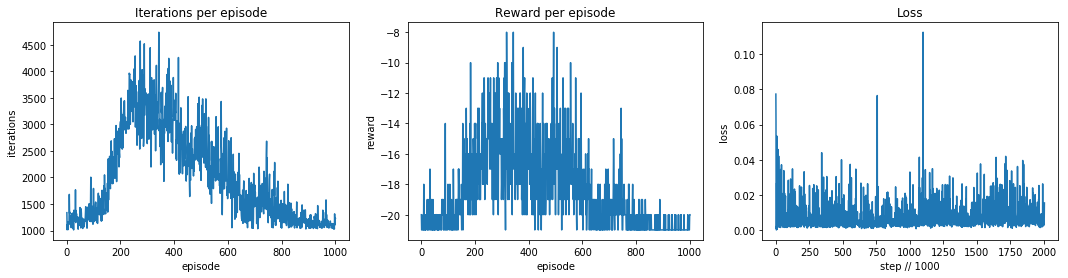

In [20]:
episode_range = np.arange(len(iters_per_episode)) + 1
iter_range = np.arange(len(loss_per_iter)) + 1

plt.figure(figsize=(18, 4))
plt.subplot(1, 3, 1)
plt.title('Iterations per episode')
plt.plot(episode_range, iters_per_episode)
plt.ylabel('iterations')
plt.xlabel('episode')

plt.subplot(1, 3, 2)
plt.title('Reward per episode')
plt.plot(episode_range, reward_per_episode)
plt.ylabel('reward')
plt.xlabel('episode')

plt.subplot(1, 3, 3)
plt.title('Loss')
plt.plot(iter_range[::1000] // 1000, loss_per_iter[::1000])
plt.ylabel('loss')
plt.xlabel('step // 1000')
plt.show()

__Plots (zoom in :))__

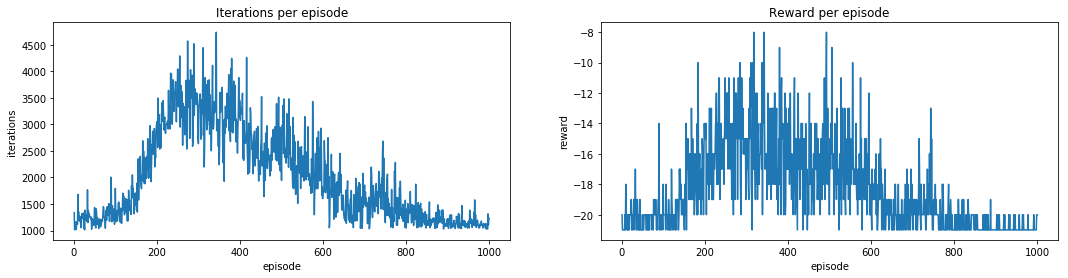

In [26]:
plt.figure(figsize=(18, 4))
plt.subplot(1, 2, 1)
plt.title('Iterations per episode')
plt.plot(episode_range, iters_per_episode)
plt.ylabel('iterations')
plt.xlabel('episode')

plt.subplot(1, 2, 2)
plt.title('Reward per episode')
plt.plot(episode_range, reward_per_episode)
plt.ylabel('reward')
plt.xlabel('episode')
plt.show()

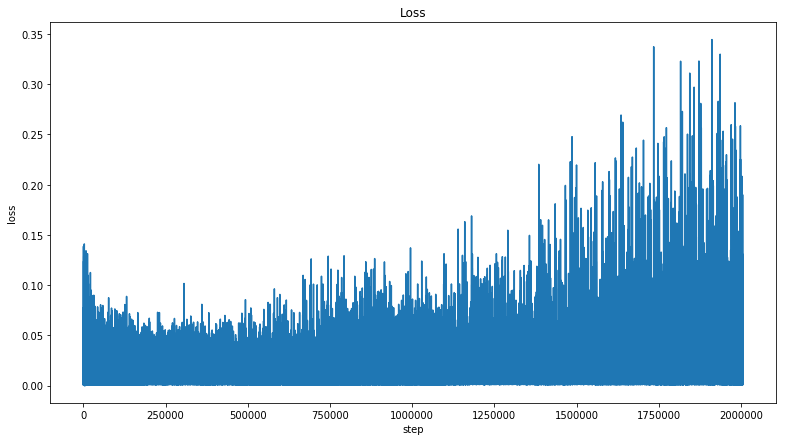

In [27]:
plt.figure(figsize=(13, 7))
plt.title('Loss')
plt.plot(iter_range, loss_per_iter)
plt.ylabel('loss')
plt.xlabel('step')
plt.show()